## Соединяем данные из датасета и базы чтобы замапить territory_id по oktmo

In [23]:
import pandas as pd

tech_indincators = pd.read_pickle('/root/blocksnet/tests/data/tep.pickle').fillna(0)
social_indicators = pd.read_pickle('/root/blocksnet/tests/data/indicators.pickle').fillna(0)

# Предсказание СЭР

In [24]:
from blocksnet.machine_learning.regression import SocialRegressor

ir = SocialRegressor()

In [25]:
X_train, X_test, y_train, y_test = ir.get_train_data(tech_indincators=tech_indincators, social_indicators=social_indicators)

2025-05-20 11:58:10.789 | INFO     | blocksnet.machine_learning.regression.social.core:_initialize_x:40 - Fitting the scaler
2025-05-20 11:58:10.815 | INFO     | blocksnet.machine_learning.regression.social.core:_initialize_y:68 - Fitting the scaler


In [32]:
y_train

,Численность населения,Площадь территории,Средняя доступность до федеральных транспортных магистралей,Средняя доступность до центра региона,Протяженность дорог регионального значения,Протяженность дорог местного значения,Количество остановок общественного транспорта,Средняя доступность автозаправочных станций,Средняя доступность международных аэропортов,Средняя доступность аэропортов местного значения,...,Обеспеченность воркаутами / школьными спортзалами,Обеспеченность спортзалами ОП / фитнес-центрами,Обеспеченность пунктами доставки / почтовыми отделениями,Обеспеченность отделениями банков,Обеспеченность остановками ОТ,Обеспеченность парковками,Обеспеченность автозаправками,Обеспеченность автосалонами / автосервисами,Обеспеченность опорными пунктами полиции,Связанность общественным транспортом
41,0.072668,0.028242,9.349760e-305,0.461377,0.082205,0.332653,0.218579,0.115736,0.567026,0.523973,...,1.00,1.00,1.00,1.00,1.00,0.93,1.00,1.00,1.0,2.135181e-306
109,0.238770,0.011686,9.704660e-305,0.167020,0.043457,0.186578,0.284153,0.008597,0.267954,0.315802,...,1.00,1.00,1.00,1.00,0.97,0.86,1.00,1.00,1.0,1.380002e-306
115,0.120634,0.121247,6.926099e-305,0.200185,0.272205,0.941579,0.289617,0.169068,0.294519,0.332436,...,0.86,0.73,0.96,0.87,0.77,0.25,0.58,0.87,1.0,1.444006e-306
83,0.091423,0.044798,1.410697e-305,0.051572,0.105828,0.498728,0.251366,0.178590,0.149376,0.150318,...,1.00,1.00,1.00,1.00,0.73,0.31,0.89,0.55,1.0,1.371480e-306
103,0.477587,0.009576,3.419827e-304,0.358592,0.134480,0.130293,0.502732,0.032585,0.466106,0.540607,...,1.00,0.60,1.00,1.00,0.85,1.00,1.00,0.79,1.0,1.688998e-306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.016487,0.199805,1.866003e-304,0.579070,0.124911,0.105577,0.060109,0.198662,0.610275,0.299168,...,0.00,0.63,1.00,1.00,0.94,0.49,1.00,1.00,1.0,1.999474e-306
19,0.120625,0.089109,1.908056e-304,0.451806,0.068054,0.119336,0.131148,0.104413,0.507470,0.434932,...,1.00,0.75,1.00,1.00,0.85,0.84,1.00,1.00,1.0,1.651138e-306
102,0.009115,0.102581,4.007692e-304,0.422313,0.161755,0.119395,0.081967,0.086400,0.533230,0.538160,...,1.00,0.00,0.83,1.00,1.00,0.29,1.00,0.00,1.0,1.827297e-306
199,0.105574,0.004058,1.696619e-305,0.127583,0.069843,0.223318,0.245902,0.092769,0.224731,0.341732,...,1.00,1.00,1.00,1.00,1.00,0.35,1.00,1.00,1.0,1.325521e-306


In [26]:
preds, mse = ir.train(X_train=X_train, y_train=y_train)

Средняя MSE: 0.002203578991715699


## Получаем доверительные интервалы с помощью бутстрапинга

Чем больше значение B (количество ресемплов), тем точнее предсказания интервалов

In [27]:
mean_preds, ci_lower, ci_upper, pi_lower, pi_upper = ir.compute_bootstrap_intervals(X_train=X_train,y_train=y_train,X_test=X_test, B=3)

Выполняется бутстрэп (3 повторов)...


Bootstrapping: 100%|██████████| 3/3 [00:04<00:00,  1.48s/it]


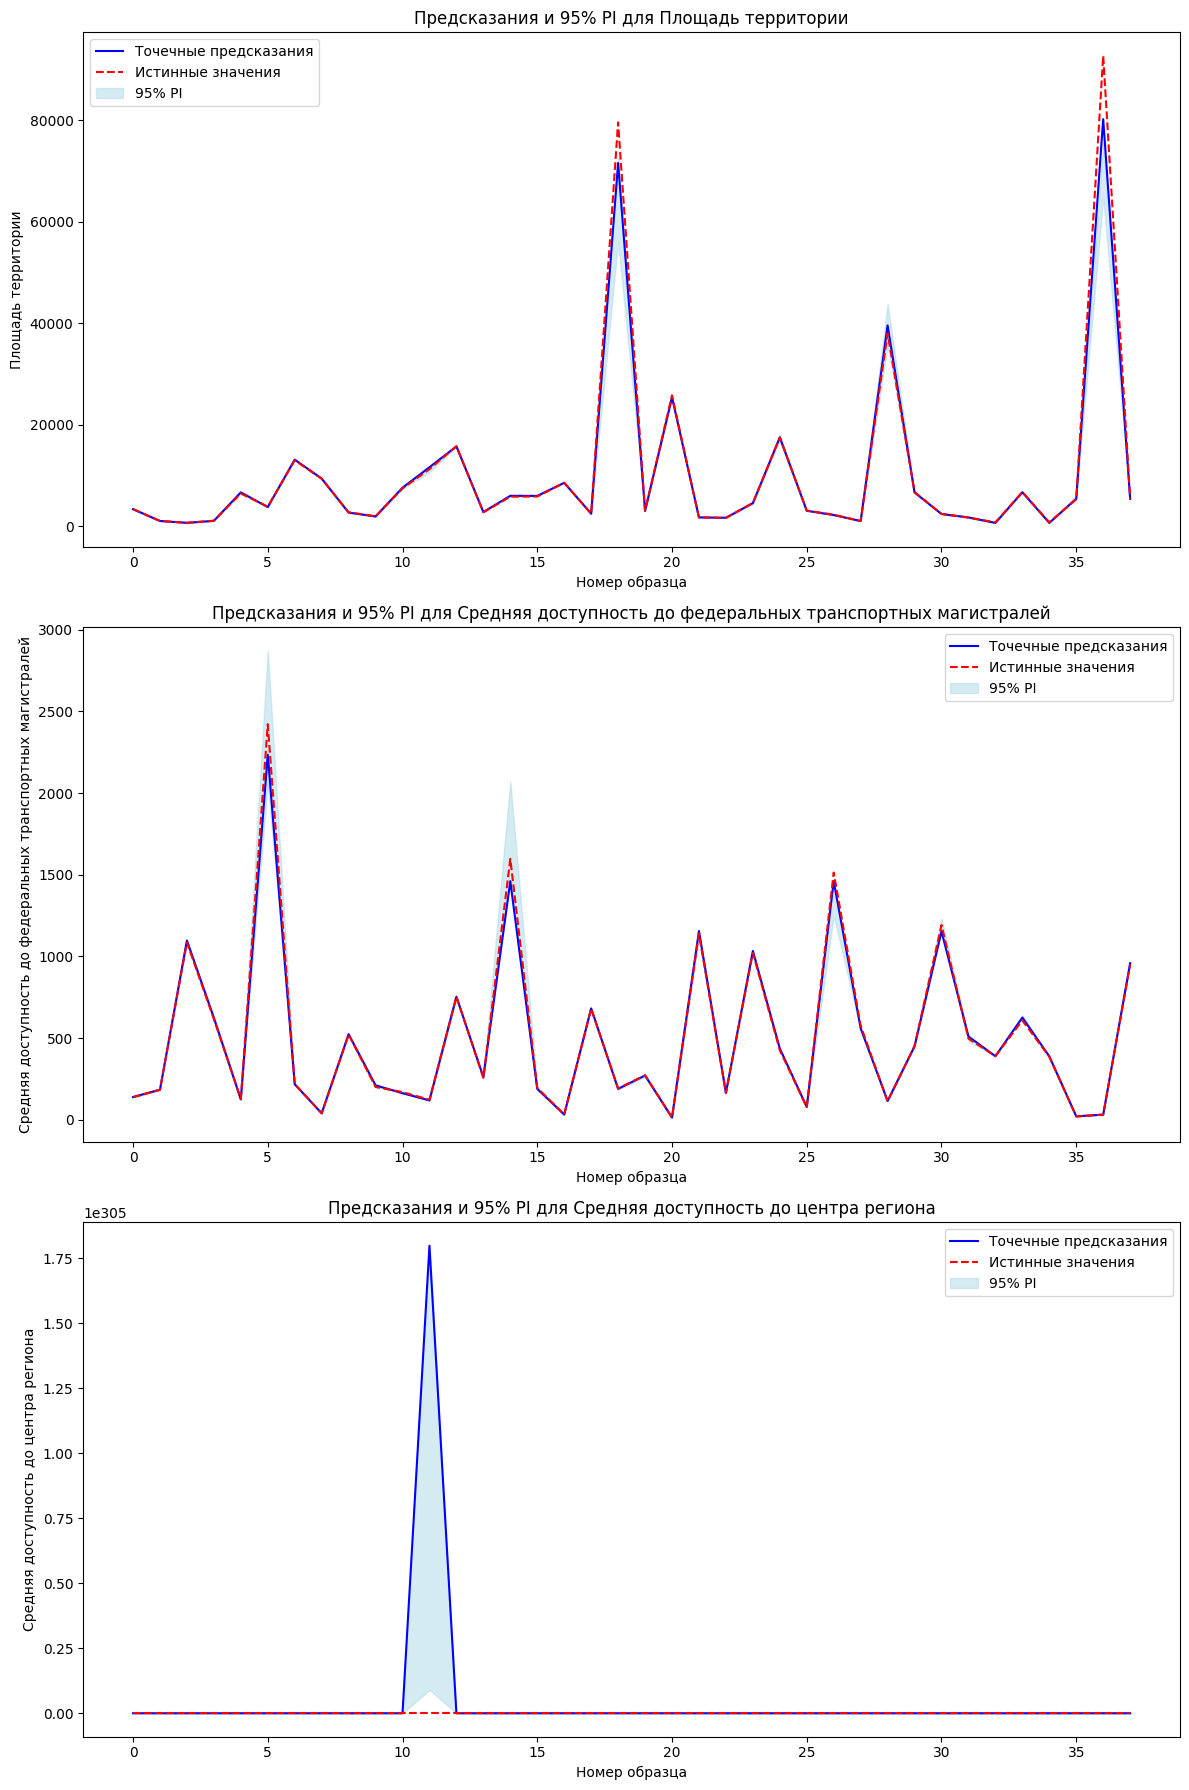

In [ ]:
# в column_names можно передать 
ir.plot_prediction_intervals(mean_preds, pi_lower, pi_upper, y_test, column_names=y_train.columns.tolist()[1:4], inverse_transform=True)

## Визуализация важности фичей

Общая средняя важность признаков:
                  mean_importance
site_area                0.218358
living_area              0.123421
non_living_area          0.118474
population               0.107652
build_floor_area         0.105754
recreation               0.091068
residential              0.078736
footprint_area           0.061074
industrial               0.056516
special                  0.038947


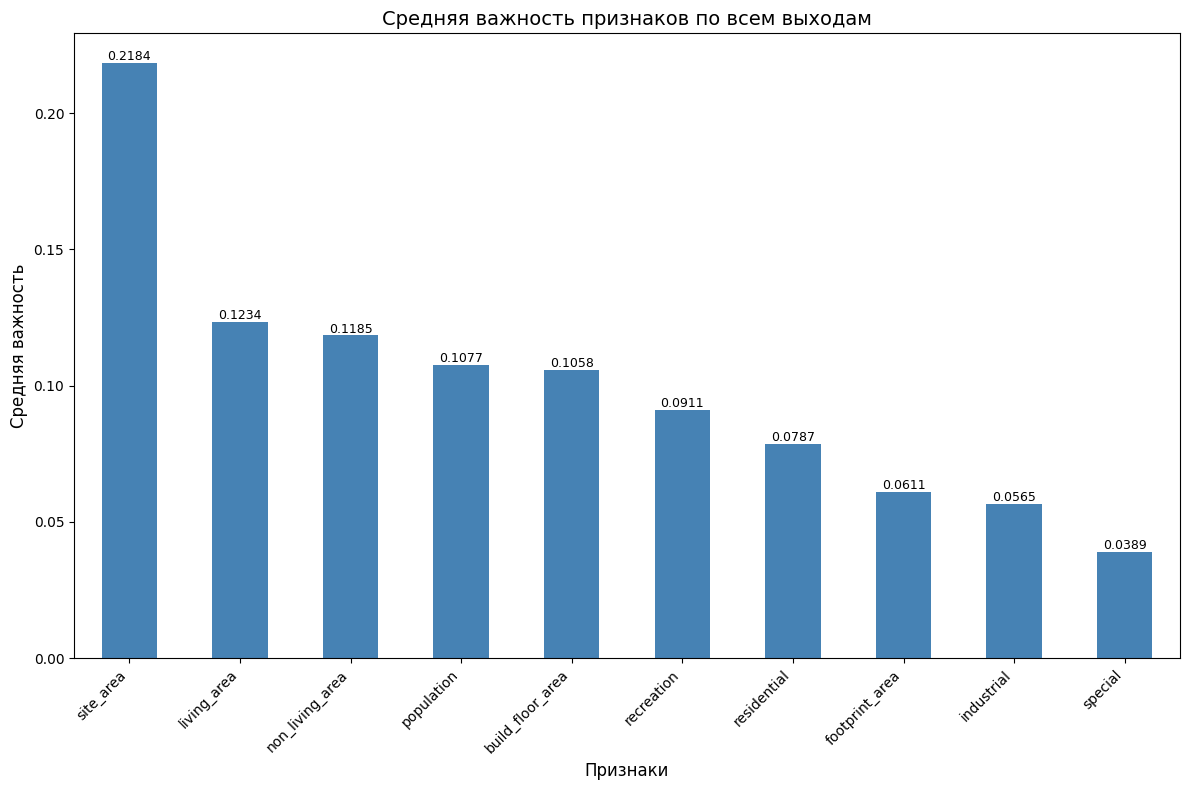

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Получение важности признаков
feature_importances = []
feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"feature_{i}" for i in range(X_train.shape[1])]
output_names = y_train.columns if hasattr(y_train, 'columns') else [f"target_{i}" for i in range(y_train.shape[1])]

for i, estimator in enumerate(ir.model.estimators_):
    # Для каждого отдельного регрессора
    importances = estimator.feature_importances_
    feature_importances.append(importances)
    
    # Вывод важности для каждого выхода
    target_name = output_names[i]


feature_importance_df = pd.DataFrame(
    np.array(feature_importances).T,
    index=feature_names,
    columns=output_names
)

# Средняя важность по всем выходам
feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
feature_importance_df = feature_importance_df.sort_values('mean_importance', ascending=False)

print("Общая средняя важность признаков:")
print(feature_importance_df[['mean_importance']])

# Визуализация средней важности признаков
plt.figure(figsize=(12, 8))
ax = feature_importance_df['mean_importance'].plot(kind='bar', color='steelblue')
plt.title('Средняя важность признаков по всем выходам', fontsize=14)
plt.ylabel('Средняя важность', fontsize=12)
plt.xlabel('Признаки', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем значения над столбцами
for i, v in enumerate(feature_importance_df['mean_importance']):
    ax.text(i, v + 0.001, f'{v:.4f}', ha='center', fontsize=9)

plt.show()

## Ошибка на разных таргетах

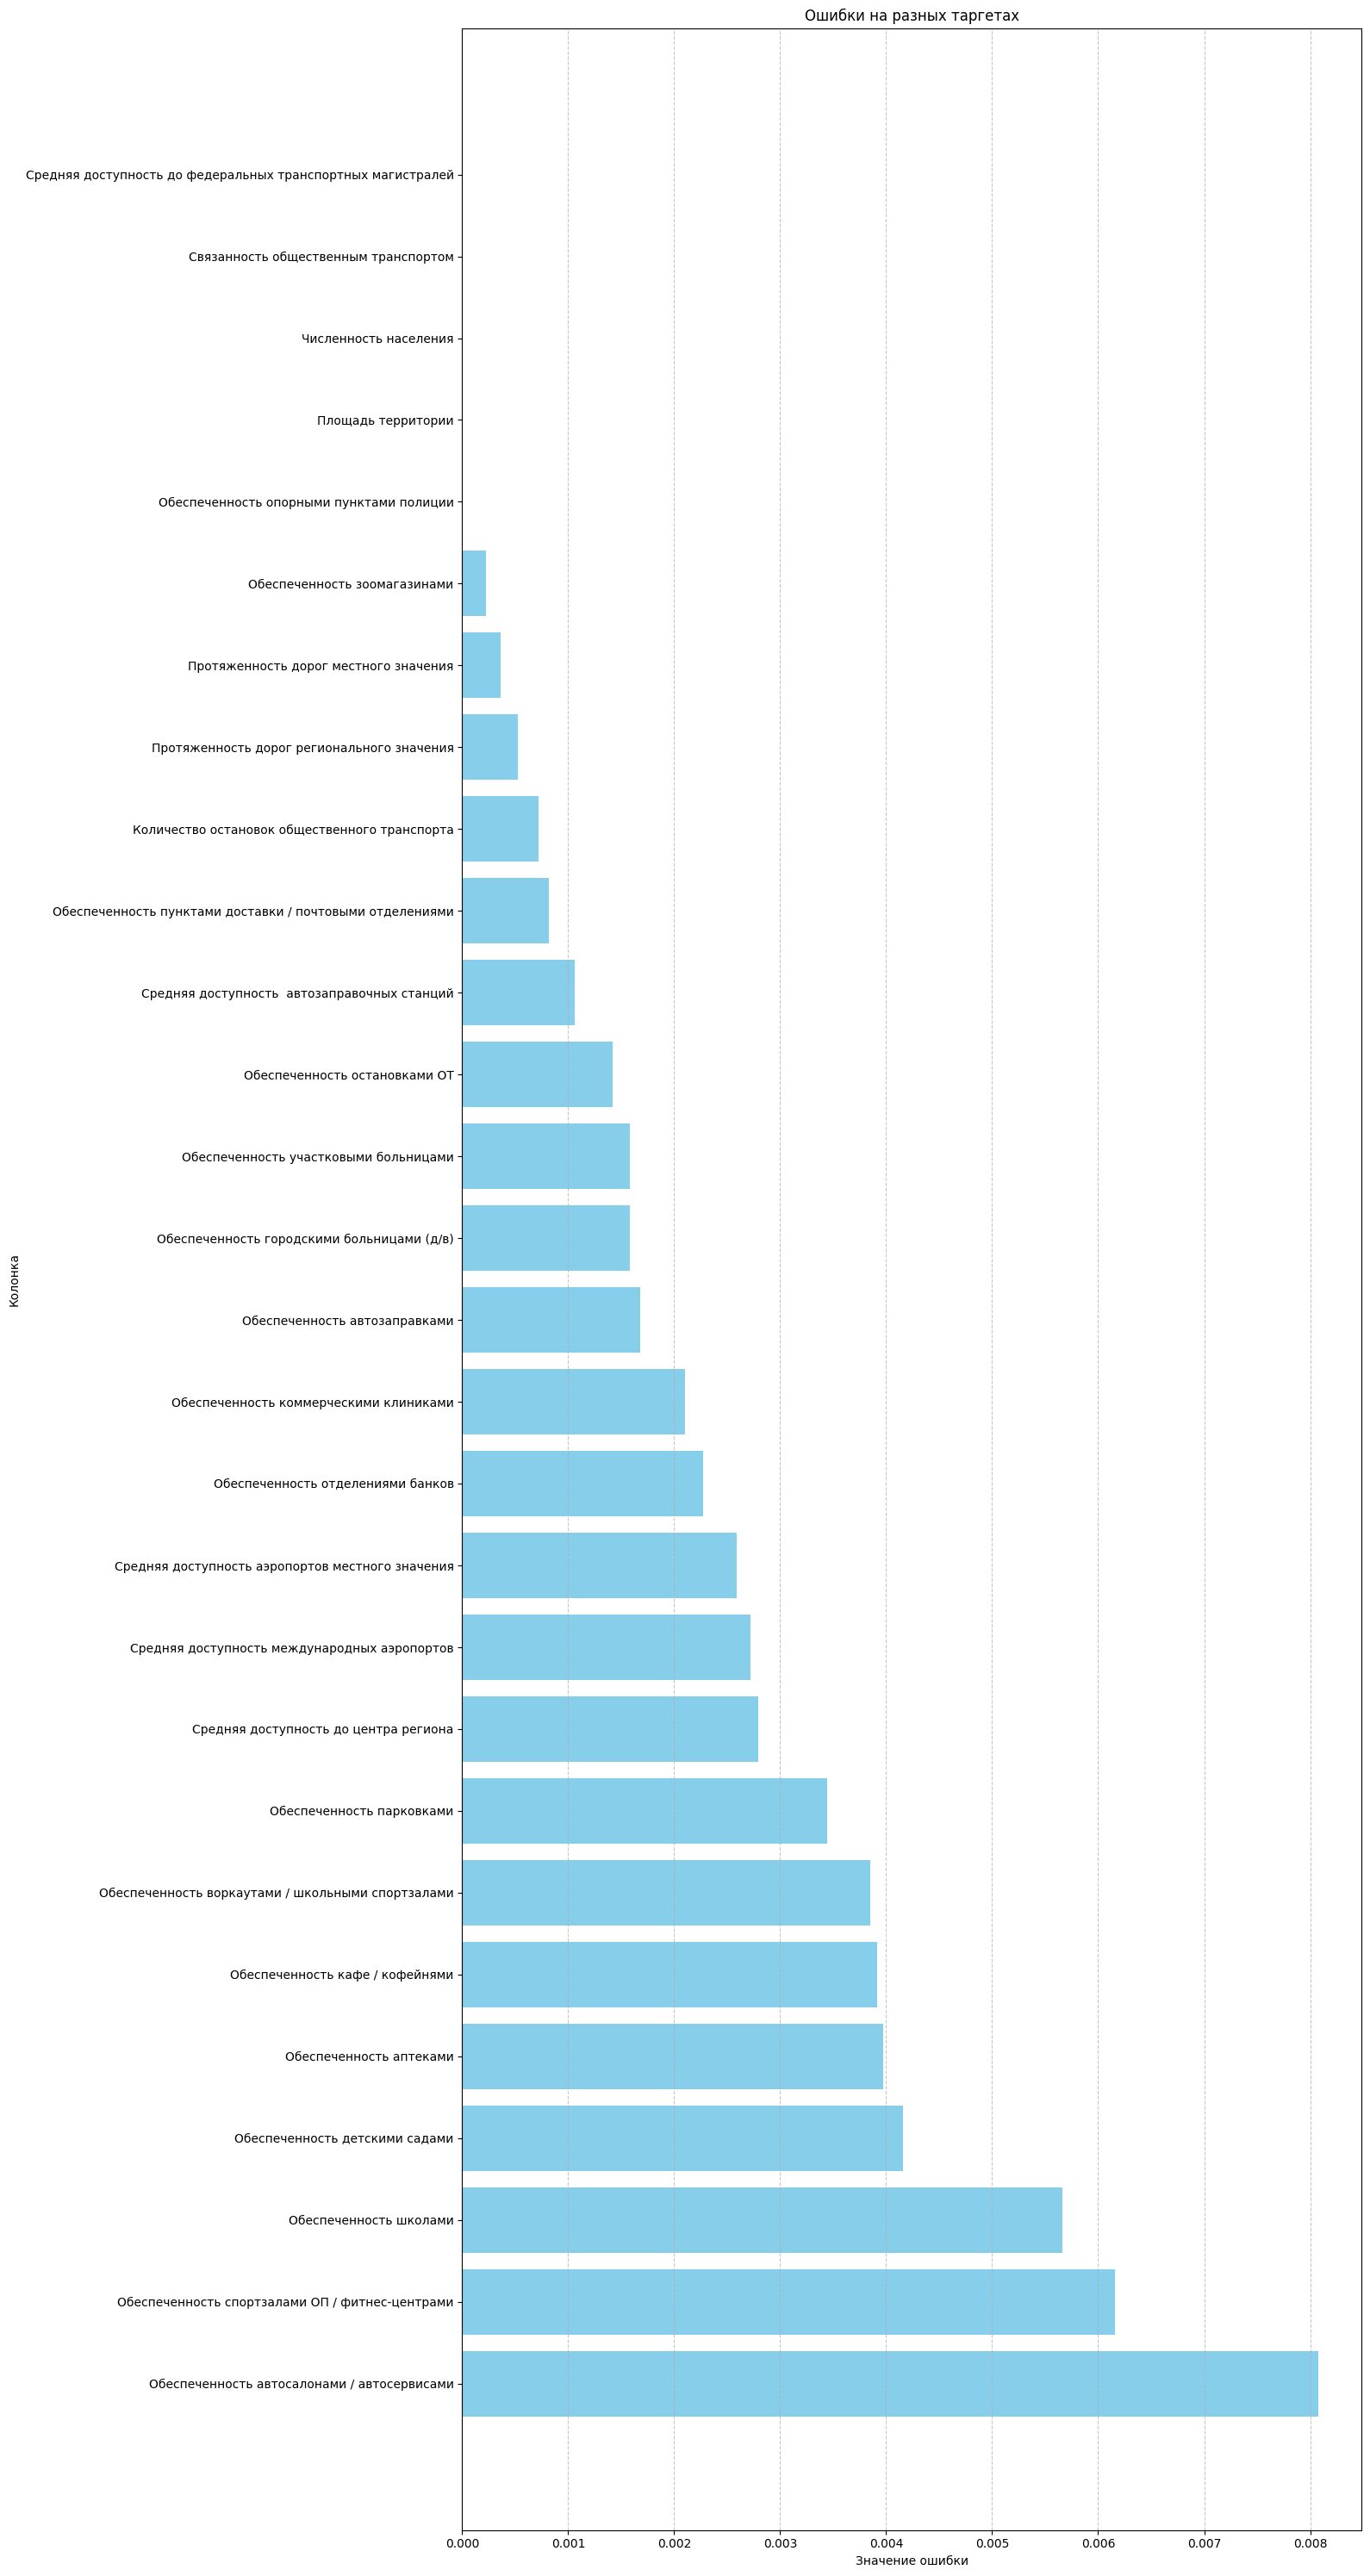

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Предположим, что mse — список значений ошибок, а Y.columns — список названий колонок
# Сортируем по убыванию
sorted_indices = np.argsort(mse)[::-1]
sorted_mse = np.array(mse)[sorted_indices]
sorted_columns = np.array(y_train.columns)[sorted_indices]

# Построение горизонтальной гистограммы
plt.figure(figsize=(16, 30))
plt.barh(sorted_columns, sorted_mse, color='skyblue')

# Добавим подписи и заголовок
plt.ylabel('Колонка')
plt.xlabel('Значение ошибки')
plt.title('Ошибки на разных таргетах')

# Сетка и отображение
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Предсказание LIME

Показывает влияние фичей на конкретное предсказание

Mean Squared Error: 0.070
Predicted value: 0.9496701004025547
Real value: 1.0
Explanation:
[('0.01 < site_area <= 0.05', 0.10085652353683702), ('recreation <= 0.00', 0.04585556403246259), ('0.02 < population <= 0.04', 0.04302802354666921), ('0.13 < residential <= 0.23', 0.029314574550491072), ('0.07 < footprint_area <= 0.13', 0.020370904802657432), ('0.00 < living_area <= 0.01', 0.018037321148712104), ('0.03 < build_floor_area <= 0.06', -0.01227918354553109), ('0.00 < special <= 0.00', -0.009165143560643664), ('0.06 < non_living_area <= 0.12', 0.0028529812248362287), ('0.03 < industrial <= 0.10', 0.0022316926968332044)]


/root/blocksnet/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


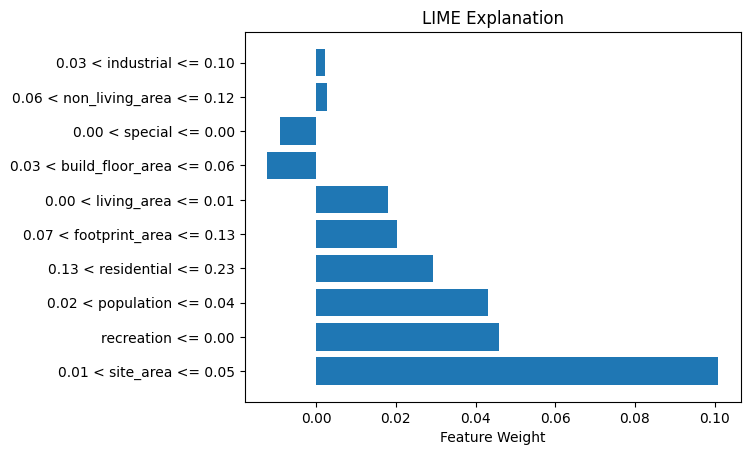

In [33]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lime.lime_tabular import LimeTabularExplainer


y_train = y_train.fillna(0)
# Базовая модель GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Обучение модели
gbr.fit(X_train, y_train['Обеспеченность аптеками'])

# Пример предсказания
y_pred = gbr.predict(X_test)

# Оценка качества
mse = mean_squared_error(y_test['Обеспеченность аптеками'], y_pred)
print(f'Mean Squared Error: {mse:.3f}')

# Создание LIME объяснителя для табличных данных
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Преобразуем DataFrame в numpy массив
    feature_names=X_train.columns,  # Указываем имена признаков
    class_names=[str(i) for i in range(y_train.shape[1])],  # Если многовыходная регрессия
    mode='regression',  # Тип задачи: регрессия
    random_state=42
)

# Выбираем одно наблюдение для интерпретации (например, первое из теста)
i = 0
instance = X_test.iloc[i].values.reshape(1, -1)

# Получаем объяснение для выбранного примера
explanation = explainer.explain_instance(instance[0], gbr.predict)

# Если нужно просто вывести данные:
print("Predicted value:", y_pred[i])
print('Real value:', y_test['Обеспеченность аптеками'].iloc[0])
print("Explanation:")
print(explanation.as_list())


import matplotlib.pyplot as plt

# Получаем объяснение как список
explanation_list = explanation.as_list()

# Разбиваем объяснение на признаки и веса
features, weights = zip(*explanation_list)

# Строим график
plt.barh(features, weights)
plt.xlabel("Feature Weight")
plt.title("LIME Explanation")
plt.show()